# 📊 TRABAJO FINAL - ANÁLISIS DE SERIES DE TIEMPO

## Universidad de Buenos Aires
### Maestria en Inteligencia Artificial
### Análisis de Series de Tiempo

**Docente:** Camilo Argoty  
**Fecha de Entrega:** 18 de Junio, 7:00 PM

---

## 👥 INTEGRANTES DEL GRUPO

1. **Jorge Hernán Cuenca Marín** - Código: A0805

---

# PARTE 1: INFORME DE ANÁLISIS (50% de la calificación)

## 1.1 Planteamiento de la Pregunta de Investigación

### Pregunta Principal:

**"¿Cómo han evolucionado los patrones de volatilidad y tendencia del precio de Bitcoin en los últimos 5 años (2020-2025), y qué modelo de series de tiempo (ARIMA, Suavizado Exponencial o Prophet) ofrece mejores pronósticos a corto plazo (30 días) en términos de precisión y capacidad de capturar la volatilidad característica de las criptomonedas?"**

### Preguntas Secundarias:

1. ¿La serie de precios de Bitcoin presenta estacionariedad o requiere diferenciación?
2. ¿Qué patrones estacionales o cíclicos se pueden identificar en el precio de Bitcoin?
3. ¿Cuál de los tres modelos (ARIMA, Suavizado Exponencial, Prophet) minimiza el error de pronóstico?
4. ¿Los modelos pueden anticipar cambios bruscos de volatilidad?

### Justificación:

Bitcoin es el activo digital más importante del mundo, con una capitalización de mercado que supera los cientos de miles de millones de dólares. Su alta volatilidad lo convierte en un caso de estudio ideal para modelos de series de tiempo, ya que presenta:

- **Tendencias claras** (bullish/bearish markets)
- **Alta volatilidad** (cambios porcentuales significativos en cortos periodos)
- **Posible estacionalidad** (patrones relacionados con eventos del mercado)
- **Relevancia práctica** (trading, inversión, gestión de riesgo)

---

## 1.2 Descripción de los Datos

### Fuente de los Datos:

- **Origen:** CryptoCompare API (https://www.cryptocompare.com/)
- **Período:** 14 de Abril 2020 - 5 de Octubre 2025 (2,001 observaciones)
- **Frecuencia:** Diaria
- **Par de trading:** BTC/USD (Bitcoin en Dólares Estadounidenses)

### Descripción de los Atributos:

| Atributo | Tipo de Dato | Descripción |
|----------|--------------|-------------|
| **Date** | datetime | Fecha de la observación (YYYY-MM-DD). Variable temporal que sirve como índice de la serie. |
| **Open** | float | Precio de apertura en USD al inicio del día. Representa el primer precio transado en el período de 24 horas. |
| **High** | float | Precio máximo alcanzado durante el día en USD. Indica el punto más alto de valor en el período. |
| **Low** | float | Precio mínimo alcanzado durante el día en USD. Indica el punto más bajo de valor en el período. |
| **Close** | float | **VARIABLE PRINCIPAL DE ANÁLISIS**. Precio de cierre en USD al final del día. Es la variable dependiente que modelaremos. |
| **Volume** | float | Volumen total de Bitcoin transado en el día. Medido en unidades de BTC. Indica la actividad del mercado. |

### Justificación de la Elección:

Se seleccionó el **precio de cierre (Close)** como variable objetivo porque:
1. Es el precio más representativo del día
2. Es el más usado en análisis técnico y financiero
3. Refleja el consenso del mercado al final de cada período
4. Permite comparabilidad con otros estudios académicos

---

# PARTE 2: CÓDIGO PYTHON (50% de la calificación)

## 2.1 Importación de Librerías

In [1]:
# ============================================================================
# LIBRERÍAS PARA MANIPULACIÓN DE DATOS
# ============================================================================
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# ============================================================================
# LIBRERÍAS PARA VISUALIZACIÓN
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ============================================================================
# LIBRERÍAS PARA MODELOS DE SERIES DE TIEMPO
# ============================================================================

# Estadísticas y tests
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo 1: ARIMA/SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelo 2: Suavizado Exponencial (Holt-Winters)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Modelo 3: Prophet de Facebook
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print("⚠️ Prophet no está instalado. Ejecuta: pip install prophet")
    PROPHET_AVAILABLE = False

# ============================================================================
# MÉTRICAS DE EVALUACIÓN
# ============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============================================================================
# CONFIGURACIÓN
# ============================================================================
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Configuración de figuras
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11

print("✓ Todas las librerías importadas correctamente")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

Importing plotly failed. Interactive plots will not work.


✓ Todas las librerías importadas correctamente
✓ Pandas version: 2.3.3
✓ NumPy version: 2.3.3


## 2.1.a) LIMPIEZA Y PREPARACIÓN DE LOS DATOS

Esta sección cumple con el requisito **1.a** del trabajo: *Limpieza y preparación de los datos*

In [2]:
# ============================================================================
# CARGA DE DATOS
# ============================================================================

print("="*80)
print("PASO 1: CARGA DE DATOS")
print("="*80)

# Cargar el dataset
df = pd.read_csv('../data/raw/bitcoin_historical.csv')

# Convertir la columna Date a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer Date como índice
df.set_index('Date', inplace=True)

# Ordenar por fecha (asegurar orden cronológico)
df.sort_index(inplace=True)

print(f"✓ Dataset cargado exitosamente")
print(f"✓ Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"✓ Período: {df.index.min().date()} hasta {df.index.max().date()}")
print(f"✓ Días de datos: {(df.index.max() - df.index.min()).days} días")

print("\n" + "="*80)
print("Primeras 5 observaciones:")
print("="*80)
display(df.head())

print("\n" + "="*80)
print("Últimas 5 observaciones:")
print("="*80)
display(df.tail())

PASO 1: CARGA DE DATOS
✓ Dataset cargado exitosamente
✓ Dimensiones: 2001 filas × 5 columnas
✓ Período: 2020-04-14 hasta 2025-10-05
✓ Días de datos: 2000 días

Primeras 5 observaciones:


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-14,6879.44,6937.49,6614.79,6629.54,49708.81
2020-04-15,6629.54,7207.11,6487.08,7114.55,98809.08
2020-04-16,7114.55,7155.17,7005.79,7037.12,45840.75
2020-04-17,7037.12,7304.35,7028.43,7264.29,35919.74
2020-04-18,7264.29,7276.84,7072.33,7132.88,29493.83



Últimas 5 observaciones:


,Open,High,Low,Close,Volume
Date,,,,,
2025-10-01,118666.73,121107.24,118356.65,120630.71,27985.21
2025-10-02,120630.71,123996.37,119348.63,122318.86,35664.64
2025-10-03,122318.86,122898.15,121598.23,122455.39,9977.25
2025-10-04,122455.39,125748.81,122213.36,123535.21,21834.57
2025-10-05,123535.21,124425.31,123143.47,123542.74,5028.52


In [3]:
# ============================================================================
# ANÁLISIS DE CALIDAD DE DATOS
# ============================================================================

print("="*80)
print("PASO 2: ANÁLISIS DE CALIDAD DE DATOS")
print("="*80)

# Información general
print("\nInformación del DataFrame:")
print("-"*80)
df.info()

# Estadísticas descriptivas
print("\n" + "="*80)
print("Estadísticas Descriptivas:")
print("="*80)
display(df.describe())

# Verificar valores nulos
print("\n" + "="*80)
print("DETECCIÓN DE VALORES NULOS:")
print("="*80)
null_counts = df.isnull().sum()
null_percentage = (df.isnull().sum() / len(df)) * 100

null_df = pd.DataFrame({
    'Valores Nulos': null_counts,
    'Porcentaje (%)': null_percentage
})

display(null_df)

if df.isnull().any().any():
    print("\n⚠️ Se encontraron valores nulos. Procederemos a imputarlos.")
else:
    print("\n✓ No se encontraron valores nulos en el dataset.")

PASO 2: ANÁLISIS DE CALIDAD DE DATOS

Información del DataFrame:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2020-04-14 to 2025-10-05
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2001 non-null   float64
 1   High    2001 non-null   float64
 2   Low     2001 non-null   float64
 3   Close   2001 non-null   float64
 4   Volume  2001 non-null   float64
dtypes: float64(5)
memory usage: 93.8 KB

Estadísticas Descriptivas:


,Open,High,Low,Close,Volume
count,2001.00,2001.00,2001.00,2001.00,2001.00
mean,46992.52,47969.44,45976.58,47050.82,38290.41
std,29699.25,30149.60,29247.92,29734.96,26466.46
min,6629.54,6937.49,6487.08,6629.54,3465.16
25%,23492.86,24125.33,23038.65,23533.22,20540.56
50%,40030.52,41400.48,38933.24,40078.62,32545.30
75%,63149.43,64335.08,61631.05,63168.44,48151.29
max,123535.21,125748.81,123143.47,123542.74,290986.06



DETECCIÓN DE VALORES NULOS:


,Valores Nulos,Porcentaje (%)
Open,0,0.00
High,0,0.00
Low,0,0.00
Close,0,0.00
Volume,0,0.00



✓ No se encontraron valores nulos en el dataset.


In [4]:
# ============================================================================
# LIMPIEZA DE DATOS
# ============================================================================

print("="*80)
print("PASO 3: LIMPIEZA DE DATOS")
print("="*80)

# Crear una copia para limpieza
df_clean = df.copy()

# 1. Manejo de valores nulos (si existen)
if df_clean.isnull().any().any():
    print("\n1. Imputación de valores nulos...")
    # Usamos forward fill (valores previos) seguido de backward fill
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
    print("   ✓ Valores nulos imputados usando forward fill + backward fill")
else:
    print("\n1. ✓ No hay valores nulos que impugne.")

# 2. Detectar y manejar outliers extremos
print("\n2. Detección de outliers...")
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites (usamos 3*IQR para ser menos restrictivos en crypto)
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    print(f"   - {col}: {outliers} outliers detectados (límites: [{lower_bound:.2f}, {upper_bound:.2f}])")

# NOTA: En criptomonedas, la alta volatilidad es natural, no eliminamos outliers
print("\n   ℹ️ En criptomonedas, los valores extremos son parte del fenómeno.")
print("   ℹ️ NO se eliminan outliers para preservar la naturaleza volátil de Bitcoin.")

# 3. Verificar que no haya valores negativos
print("\n3. Verificación de valores negativos...")
negative_values = (df_clean < 0).sum().sum()
if negative_values > 0:
    print(f"   ⚠️ Se encontraron {negative_values} valores negativos (anómalos)")
    df_clean = df_clean[df_clean >= 0].fillna(method='ffill')
    print("   ✓ Valores negativos corregidos")
else:
    print("   ✓ No se encontraron valores negativos")

print("\n" + "="*80)
print("RESUMEN DE LIMPIEZA:")
print("="*80)
print(f"✓ Datos originales: {len(df)} observaciones")
print(f"✓ Datos limpios: {len(df_clean)} observaciones")
print(f"✓ Diferencia: {len(df) - len(df_clean)} observaciones removidas")
print(f"✓ Calidad de datos: {(len(df_clean)/len(df))*100:.2f}% de datos preservados")

PASO 3: LIMPIEZA DE DATOS

1. ✓ No hay valores nulos que impugne.

2. Detección de outliers...
   - Open: 0 outliers detectados (límites: [-95476.85, 182119.14])
   - High: 0 outliers detectados (límites: [-96503.92, 184964.33])
   - Low: 0 outliers detectados (límites: [-92738.55, 177408.25])
   - Close: 0 outliers detectados (límites: [-95372.44, 182074.10])
   - Volume: 19 outliers detectados (límites: [-62291.63, 130983.48])

   ℹ️ En criptomonedas, los valores extremos son parte del fenómeno.
   ℹ️ NO se eliminan outliers para preservar la naturaleza volátil de Bitcoin.

3. Verificación de valores negativos...
   ✓ No se encontraron valores negativos

RESUMEN DE LIMPIEZA:
✓ Datos originales: 2001 observaciones
✓ Datos limpios: 2001 observaciones
✓ Diferencia: 0 observaciones removidas
✓ Calidad de datos: 100.00% de datos preservados


In [5]:
# ============================================================================
# CREACIÓN DE VARIABLES DERIVADAS
# ============================================================================

print("="*80)
print("PASO 4: INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)")
print("="*80)

print("\nCreando variables derivadas para análisis...\n")

# 1. Retornos diarios (log returns)
df_clean['Returns'] = np.log(df_clean['Close'] / df_clean['Close'].shift(1))
print("✓ Returns: Retornos logarítmicos diarios")

# 2. Volatilidad (desviación estándar móvil)
df_clean['Volatility_7d'] = df_clean['Returns'].rolling(window=7).std()
df_clean['Volatility_30d'] = df_clean['Returns'].rolling(window=30).std()
print("✓ Volatility_7d: Volatilidad a 7 días")
print("✓ Volatility_30d: Volatilidad a 30 días")

# 3. Medias Móviles Simples (SMA)
df_clean['SMA_7'] = df_clean['Close'].rolling(window=7).mean()
df_clean['SMA_30'] = df_clean['Close'].rolling(window=30).mean()
df_clean['SMA_90'] = df_clean['Close'].rolling(window=90).mean()
print("✓ SMA_7: Media móvil simple de 7 días")
print("✓ SMA_30: Media móvil simple de 30 días")
print("✓ SMA_90: Media móvil simple de 90 días")

# 4. Rango diario
df_clean['Daily_Range'] = df_clean['High'] - df_clean['Low']
df_clean['Daily_Range_Pct'] = (df_clean['Daily_Range'] / df_clean['Close']) * 100
print("✓ Daily_Range: Rango absoluto diario (High - Low)")
print("✓ Daily_Range_Pct: Rango diario como % del precio de cierre")

# 5. Variables temporales
df_clean['Year'] = df_clean.index.year
df_clean['Month'] = df_clean.index.month
df_clean['Day_of_Week'] = df_clean.index.dayofweek
df_clean['Quarter'] = df_clean.index.quarter
print("✓ Year, Month, Day_of_Week, Quarter: Variables temporales")

print("\n" + "="*80)
print("Dataset enriquecido:")
print("="*80)
display(df_clean.head(10))

print(f"\n✓ Total de variables: {df_clean.shape[1]}")
print(f"✓ Variables originales: 5 (Open, High, Low, Close, Volume)")
print(f"✓ Variables derivadas: {df_clean.shape[1] - 5}")

PASO 4: INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)

Creando variables derivadas para análisis...

✓ Returns: Retornos logarítmicos diarios
✓ Volatility_7d: Volatilidad a 7 días
✓ Volatility_30d: Volatilidad a 30 días
✓ SMA_7: Media móvil simple de 7 días
✓ SMA_30: Media móvil simple de 30 días
✓ SMA_90: Media móvil simple de 90 días
✓ Daily_Range: Rango absoluto diario (High - Low)
✓ Daily_Range_Pct: Rango diario como % del precio de cierre
✓ Year, Month, Day_of_Week, Quarter: Variables temporales

Dataset enriquecido:


,Open,High,Low,Close,Volume,Returns,Volatility_7d,Volatility_30d,SMA_7,SMA_30,SMA_90,Daily_Range,Daily_Range_Pct,Year,Month,Day_of_Week,Quarter
Date,,,,,,,,,,,,,,,,,
2020-04-14,6879.44,6937.49,6614.79,6629.54,49708.81,NaN,NaN,NaN,NaN,NaN,NaN,322.70,4.87,2020,4,1,2
2020-04-15,6629.54,7207.11,6487.08,7114.55,98809.08,0.07,NaN,NaN,NaN,NaN,NaN,720.03,10.12,2020,4,2,2
2020-04-16,7114.55,7155.17,7005.79,7037.12,45840.75,-0.01,NaN,NaN,NaN,NaN,NaN,149.38,2.12,2020,4,3,2
2020-04-17,7037.12,7304.35,7028.43,7264.29,35919.74,0.03,NaN,NaN,NaN,NaN,NaN,275.92,3.80,2020,4,4,2
2020-04-18,7264.29,7276.84,7072.33,7132.88,29493.83,-0.02,NaN,NaN,NaN,NaN,NaN,204.51,2.87,2020,4,5,2
2020-04-19,7132.88,7225.23,6770.07,6842.45,64707.00,-0.04,NaN,NaN,NaN,NaN,NaN,455.16,6.65,2020,4,6,2
2020-04-20,6842.45,6948.78,6779.51,6855.11,44531.91,0.00,NaN,NaN,6982.28,NaN,NaN,169.27,2.47,2020,4,0,2
2020-04-21,6855.11,7165.43,6831.44,7135.41,43780.72,0.04,0.04,NaN,7054.54,NaN,NaN,333.99,4.68,2020,4,1,2
2020-04-22,7135.41,7731.56,7041.20,7489.25,81106.87,0.05,0.03,NaN,7108.07,NaN,NaN,690.36,9.22,2020,4,2,2



✓ Total de variables: 17
✓ Variables originales: 5 (Open, High, Low, Close, Volume)
✓ Variables derivadas: 12


PASO 5: VISUALIZACIÓN EXPLORATORIA DE DATOS


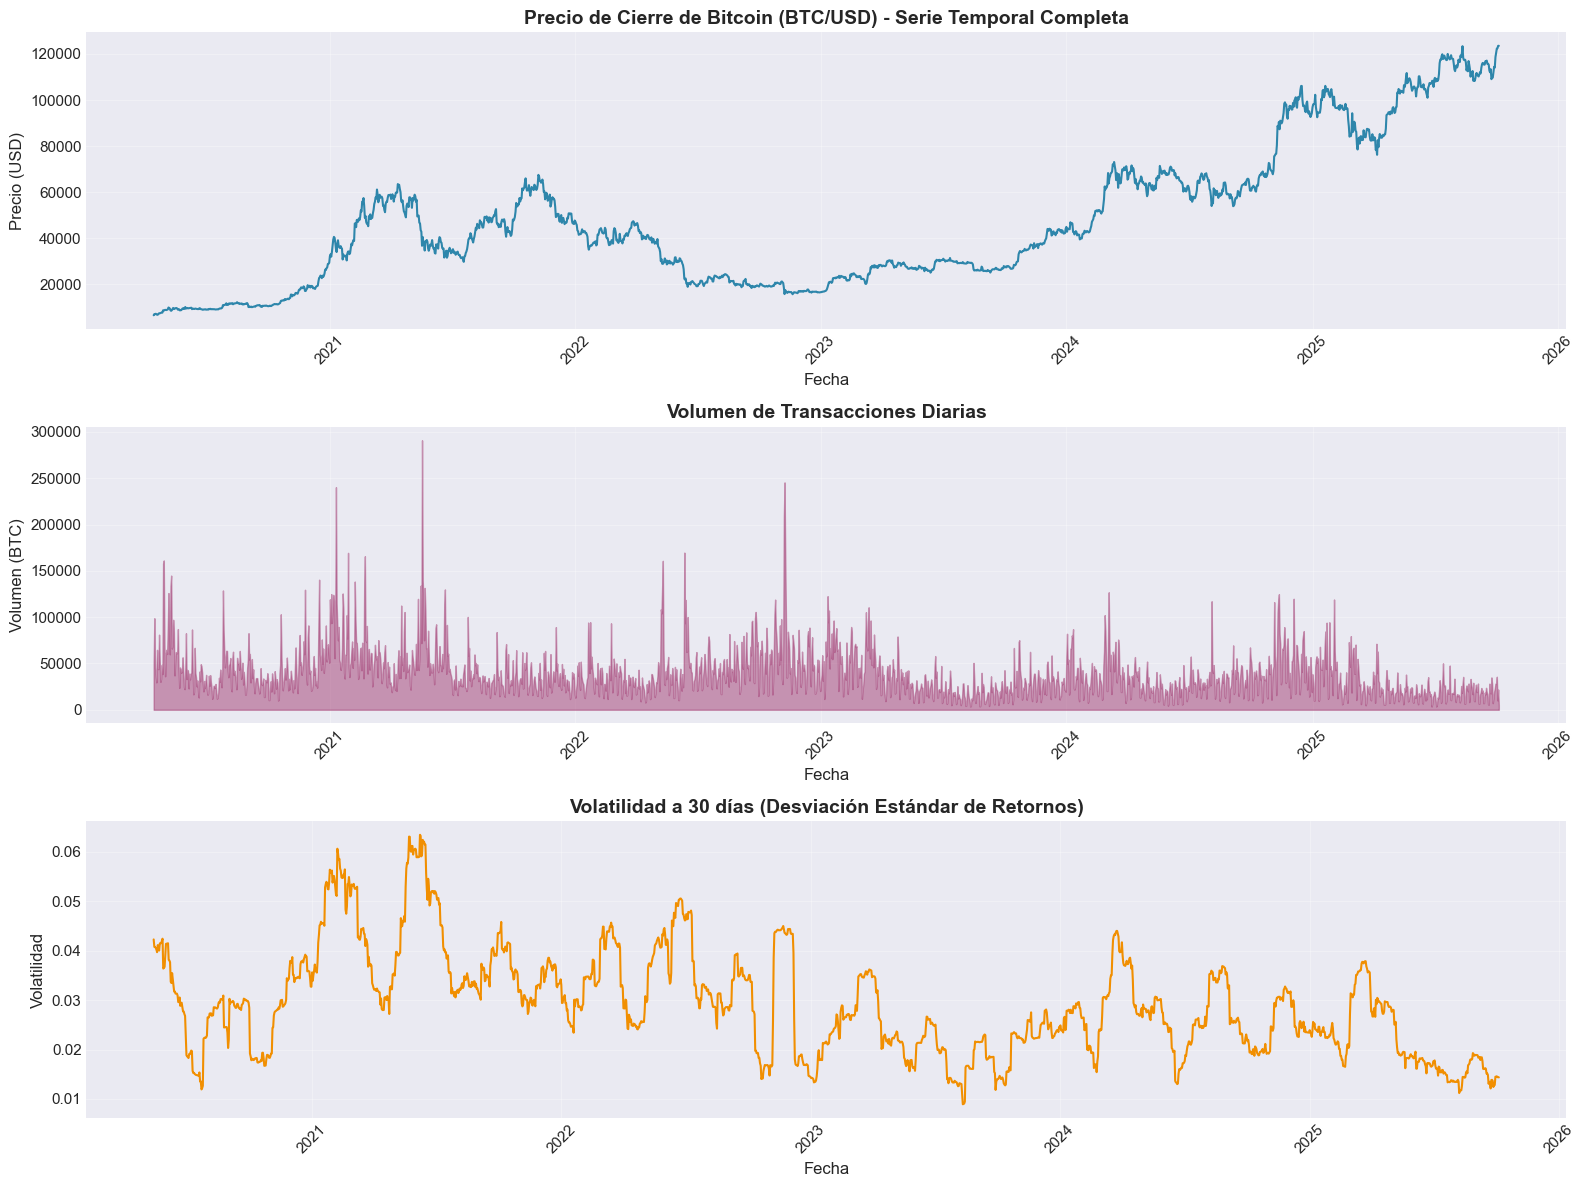


✓ Visualizaciones generadas exitosamente


In [6]:
# ============================================================================
# VISUALIZACIÓN EXPLORATORIA INICIAL
# ============================================================================

print("="*80)
print("PASO 5: VISUALIZACIÓN EXPLORATORIA DE DATOS")
print("="*80)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Gráfico 1: Precio de cierre
axes[0].plot(df_clean.index, df_clean['Close'], linewidth=1.5, color='#2E86AB')
axes[0].set_title('Precio de Cierre de Bitcoin (BTC/USD) - Serie Temporal Completa', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Precio (USD)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Volumen
axes[1].fill_between(df_clean.index, df_clean['Volume'], alpha=0.5, color='#A23B72')
axes[1].set_title('Volumen de Transacciones Diarias', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Volumen (BTC)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Gráfico 3: Volatilidad
axes[2].plot(df_clean.index, df_clean['Volatility_30d'], linewidth=1.5, color='#F18F01')
axes[2].set_title('Volatilidad a 30 días (Desviación Estándar de Retornos)', 
                  fontsize=14, fontweight='bold')
axes[2].set_xlabel('Fecha', fontsize=12)
axes[2].set_ylabel('Volatilidad', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas exitosamente")

In [7]:
# ============================================================================
# GUARDAR DATOS LIMPIOS
# ============================================================================

print("="*80)
print("PASO 6: GUARDAR DATOS PROCESADOS")
print("="*80)

# Guardar dataset procesado
df_clean.to_csv('../data/processed/bitcoin_processed.csv')
print("✓ Datos procesados guardados en: data/processed/bitcoin_processed.csv")

# Estadísticas finales
print("\n" + "="*80)
print("RESUMEN FINAL DE PREPARACIÓN DE DATOS:")
print("="*80)
print(f"✓ Observaciones totales: {len(df_clean)}")
print(f"✓ Variables totales: {df_clean.shape[1]}")
print(f"✓ Período: {df_clean.index.min().date()} a {df_clean.index.max().date()}")
print(f"✓ Días de trading: {len(df_clean)}")
print(f"✓ Valores nulos restantes: {df_clean.isnull().sum().sum()}")
print(f"\n✓ Variable objetivo (Close): Min=${df_clean['Close'].min():.2f}, Max=${df_clean['Close'].max():.2f}, Media=${df_clean['Close'].mean():.2f}")
print("\n" + "="*80)
print("✅ SECCIÓN 2.1.a) LIMPIEZA Y PREPARACIÓN COMPLETADA")
print("="*80)

PASO 6: GUARDAR DATOS PROCESADOS
✓ Datos procesados guardados en: data/processed/bitcoin_processed.csv

RESUMEN FINAL DE PREPARACIÓN DE DATOS:
✓ Observaciones totales: 2001
✓ Variables totales: 17
✓ Período: 2020-04-14 a 2025-10-05
✓ Días de trading: 2001
✓ Valores nulos restantes: 162

✓ Variable objetivo (Close): Min=$6629.54, Max=$123542.74, Media=$47050.82

✅ SECCIÓN 2.1.a) LIMPIEZA Y PREPARACIÓN COMPLETADA


---

## 2.2 Análisis Exploratorio de la Serie Temporal

Antes de modelar, es fundamental entender las características de la serie temporal.

In [8]:
# ============================================================================
# TEST DE ESTACIONARIEDAD (Augmented Dickey-Fuller)
# ============================================================================

print("="*80)
print("ANÁLISIS DE ESTACIONARIEDAD")
print("="*80)

def test_stationarity(timeseries, title):
    """
    Realiza el test de Dickey-Fuller Aumentado para verificar estacionariedad
    
    H0: La serie tiene una raíz unitaria (NO es estacionaria)
    H1: La serie es estacionaria
    
    Si p-value < 0.05, rechazamos H0 y concluimos que la serie ES estacionaria
    """
    result = adfuller(timeseries.dropna())
    
    print(f'\n{title}')
    print('='*80)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Número de lags usados: {result[2]}')
    print(f'Número de observaciones: {result[3]}')
    print('\nValores críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\n✓ CONCLUSIÓN: La serie ES ESTACIONARIA (p-value ≤ 0.05)")
        print("  → Rechazamos H0: No hay raíz unitaria")
        return True
    else:
        print("\n✗ CONCLUSIÓN: La serie NO ES ESTACIONARIA (p-value > 0.05)")
        print("  → No rechazamos H0: Existe raíz unitaria")
        print("  → Se requiere diferenciación")
        return False

# Test en el precio original
is_stationary_price = test_stationarity(df_clean['Close'], 'Test ADF - Precio de Cierre')

# Test en retornos (primera diferencia logarítmica)
is_stationary_returns = test_stationarity(df_clean['Returns'], 'Test ADF - Retornos Logarítmicos')

ANÁLISIS DE ESTACIONARIEDAD

Test ADF - Precio de Cierre
ADF Statistic: -0.039105
p-value: 0.955176
Número de lags usados: 13
Número de observaciones: 1987

Valores críticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568

✗ CONCLUSIÓN: La serie NO ES ESTACIONARIA (p-value > 0.05)
  → No rechazamos H0: Existe raíz unitaria
  → Se requiere diferenciación

Test ADF - Retornos Logarítmicos
ADF Statistic: -14.178851
p-value: 0.000000
Número de lags usados: 8
Número de observaciones: 1991

Valores críticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568

✓ CONCLUSIÓN: La serie ES ESTACIONARIA (p-value ≤ 0.05)
  → Rechazamos H0: No hay raíz unitaria



ANÁLISIS DE AUTOCORRELACIÓN


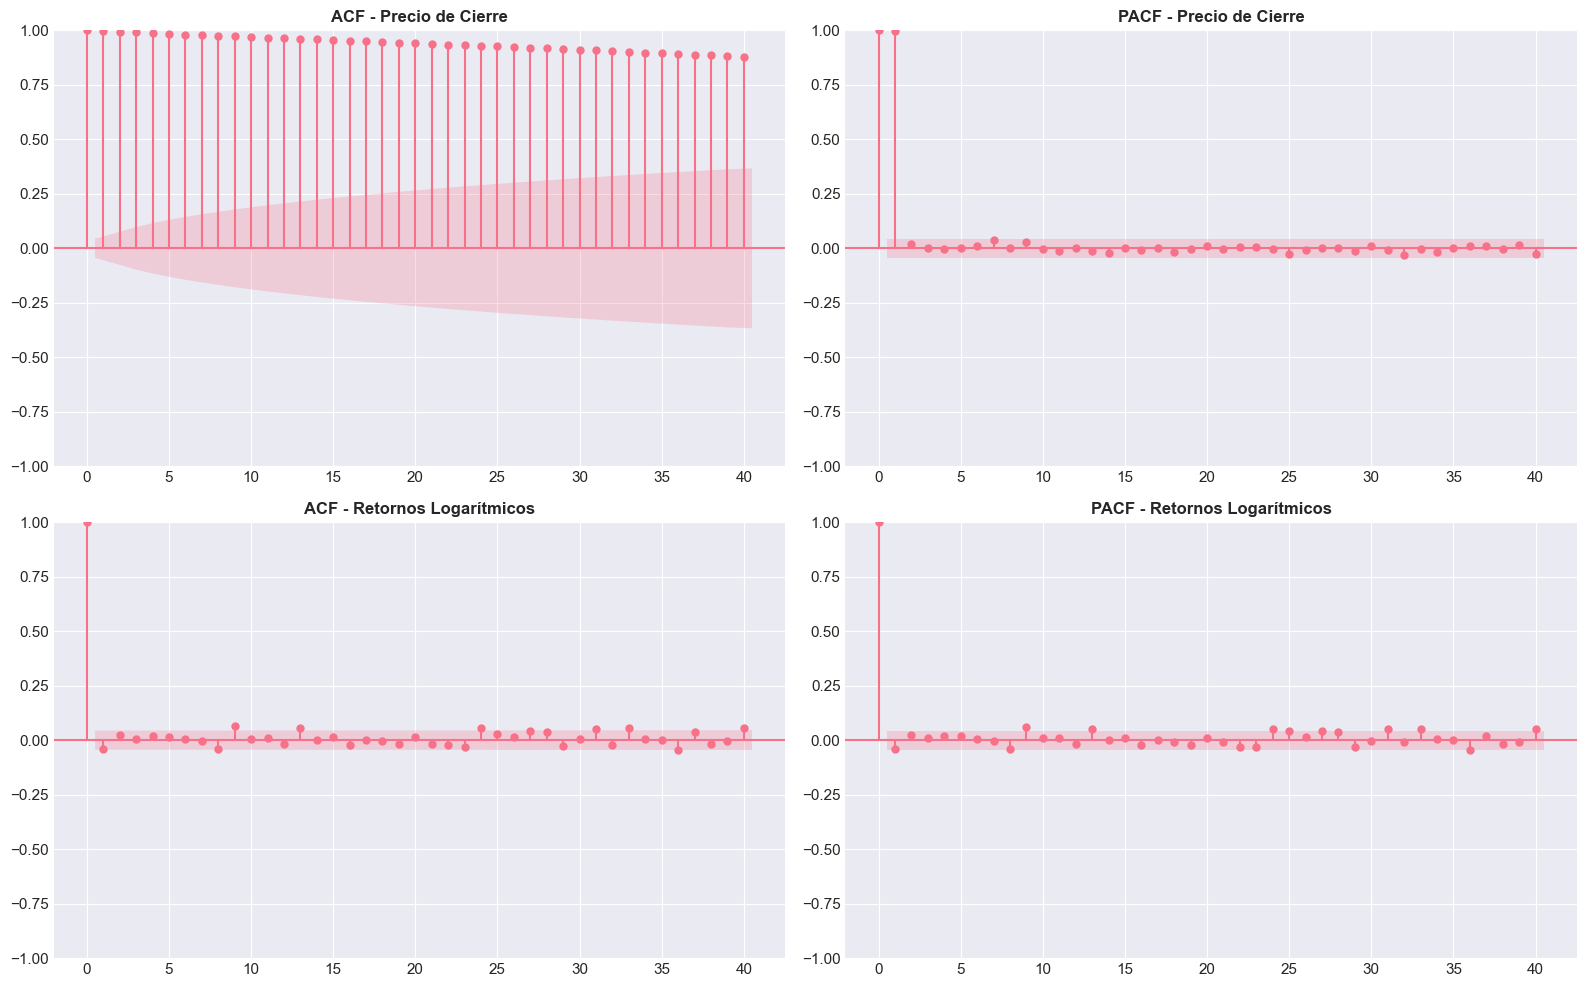


✓ Gráficos de autocorrelación generados

INTERPRETACIÓN:
- ACF muestra la correlación con todos los lags anteriores
- PACF muestra la correlación directa con cada lag (controlando lags intermedios)
- Estos gráficos ayudan a identificar los parámetros p y q para ARIMA


In [9]:
# ============================================================================
# AUTOCORRELACIÓN (ACF) Y AUTOCORRELACIÓN PARCIAL (PACF)
# ============================================================================

print("\n" + "="*80)
print("ANÁLISIS DE AUTOCORRELACIÓN")
print("="*80)

# Usar retornos para el análisis (más probable que sea estacionario)
returns_clean = df_clean['Returns'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF y PACF para Precio
plot_acf(df_clean['Close'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Precio de Cierre', fontsize=12, fontweight='bold')

plot_pacf(df_clean['Close'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Precio de Cierre', fontsize=12, fontweight='bold')

# ACF y PACF para Retornos
plot_acf(returns_clean, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Retornos Logarítmicos', fontsize=12, fontweight='bold')

plot_pacf(returns_clean, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Retornos Logarítmicos', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Gráficos de autocorrelación generados")
print("\nINTERPRETACIÓN:")
print("- ACF muestra la correlación con todos los lags anteriores")
print("- PACF muestra la correlación directa con cada lag (controlando lags intermedios)")
print("- Estos gráficos ayudan a identificar los parámetros p y q para ARIMA")


DESCOMPOSICIÓN DE LA SERIE TEMPORAL


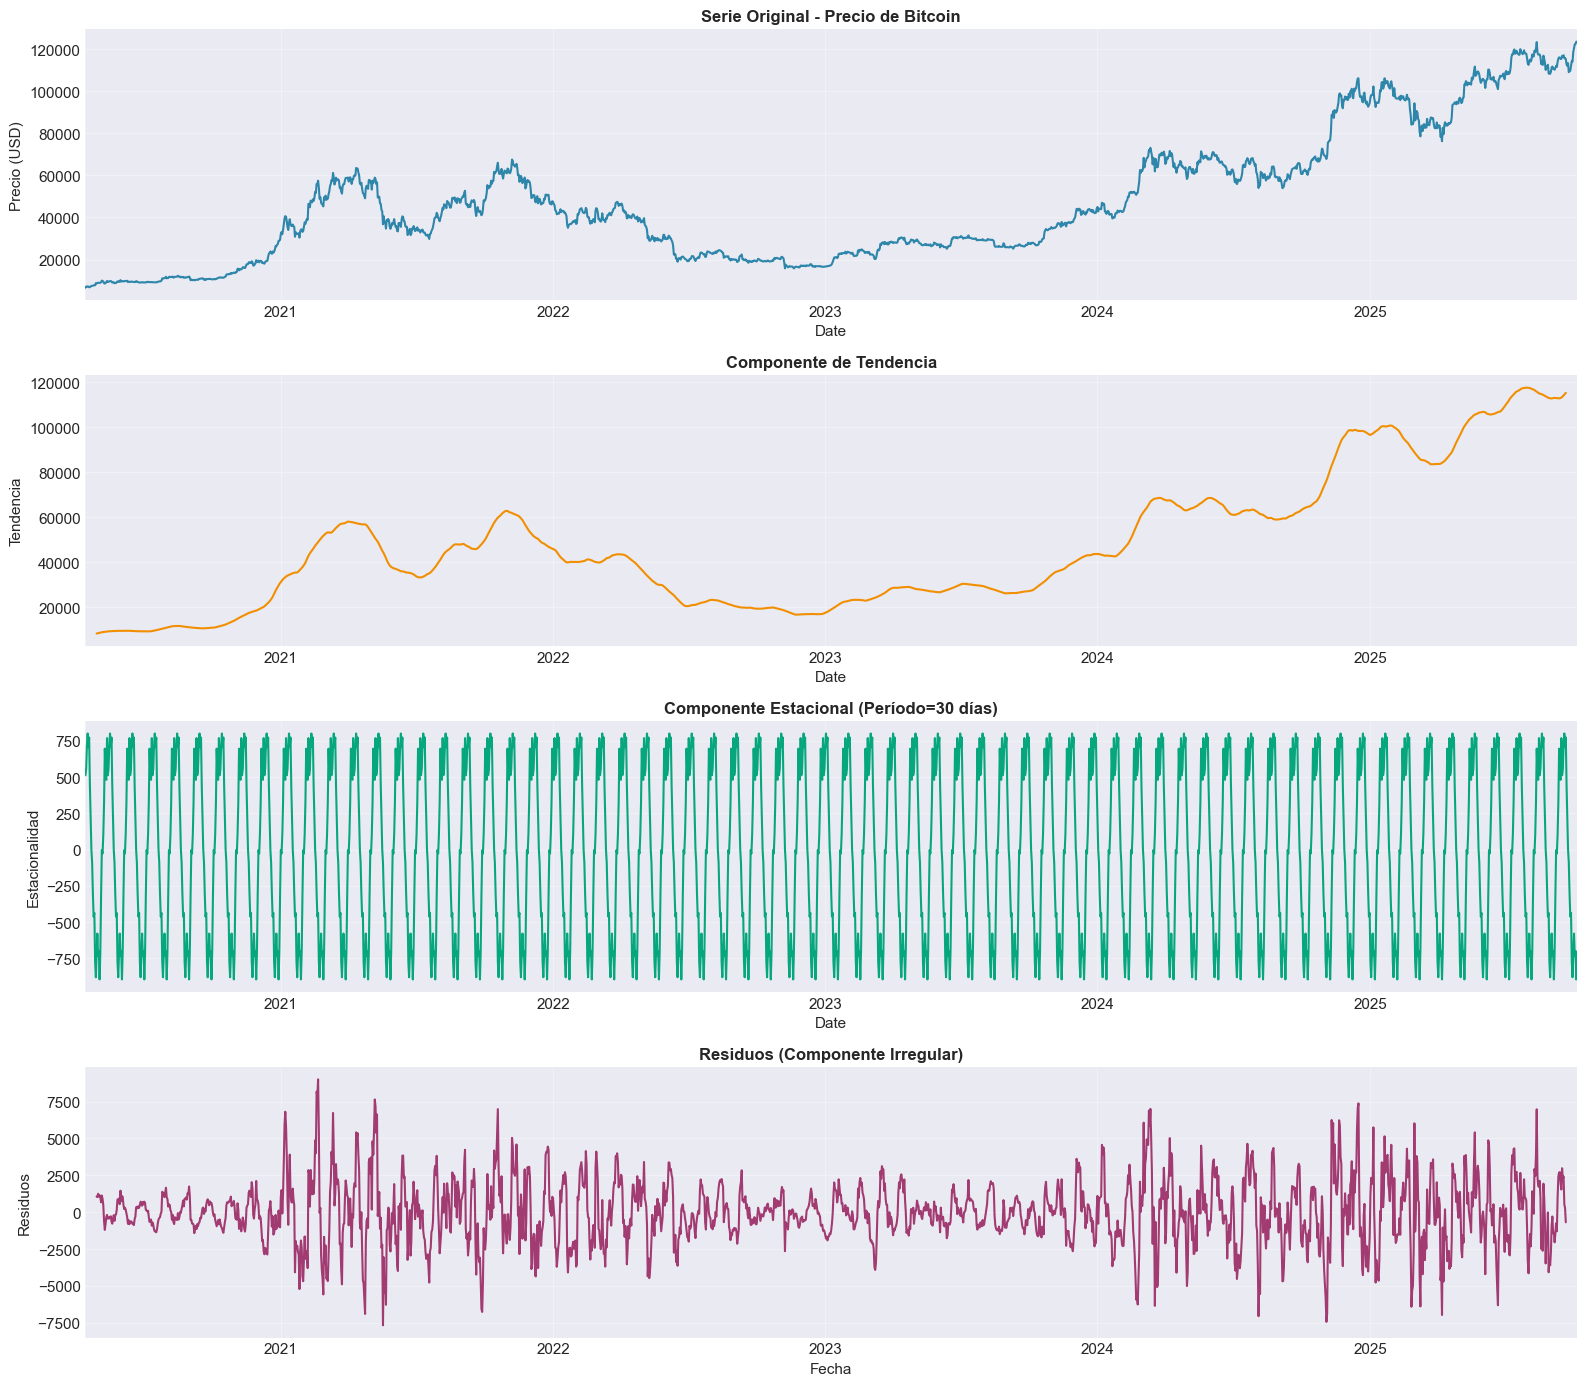


✓ Descomposición completada

COMPONENTES IDENTIFICADOS:
1. Tendencia: Movimiento general a largo plazo
2. Estacionalidad: Patrones que se repiten en períodos fijos
3. Residuos: Variación aleatoria no explicada por tendencia ni estacionalidad


In [10]:
# ============================================================================
# DESCOMPOSICIÓN DE LA SERIE TEMPORAL
# ============================================================================

print("\n" + "="*80)
print("DESCOMPOSICIÓN DE LA SERIE TEMPORAL")
print("="*80)

# Descomposición aditiva con período de 30 días
decomposition = seasonal_decompose(df_clean['Close'].dropna(), 
                                   model='additive', 
                                   period=30)

fig, axes = plt.subplots(4, 1, figsize=(16, 14))

decomposition.observed.plot(ax=axes[0], color='#2E86AB')
axes[0].set_title('Serie Original - Precio de Bitcoin', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precio (USD)')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='#F18F01')
axes[1].set_title('Componente de Tendencia', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Tendencia')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='#06A77D')
axes[2].set_title('Componente Estacional (Período=30 días)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Estacionalidad')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='#A23B72')
axes[3].set_title('Residuos (Componente Irregular)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residuos')
axes[3].set_xlabel('Fecha')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Descomposición completada")
print("\nCOMPONENTES IDENTIFICADOS:")
print("1. Tendencia: Movimiento general a largo plazo")
print("2. Estacionalidad: Patrones que se repiten en períodos fijos")
print("3. Residuos: Variación aleatoria no explicada por tendencia ni estacionalidad")


DIVISIÓN DE DATOS: ENTRENAMIENTO Y PRUEBA

✓ Datos divididos en 80% entrenamiento, 20% prueba

Conjunto de ENTRENAMIENTO:
  - Tamaño: 1600 observaciones
  - Período: 2020-04-14 a 2024-08-30
  - Precio mín: $6629.54
  - Precio máx: $73118.09
  - Precio medio: $35005.91

Conjunto de PRUEBA:
  - Tamaño: 401 observaciones
  - Período: 2024-08-31 a 2025-10-05
  - Precio mín: $53954.33
  - Precio máx: $123542.74
  - Precio medio: $95110.34


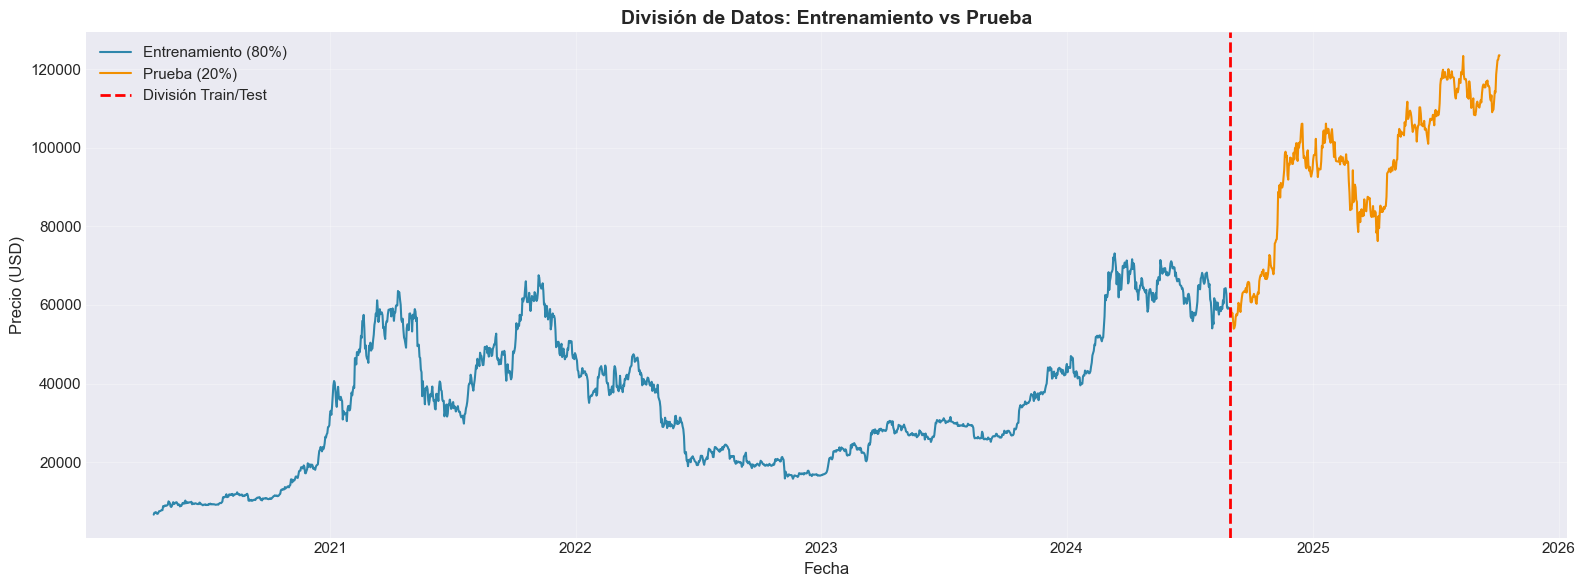


✓ Conjuntos guardados en data/processed/


In [11]:
# ============================================================================
# DIVISIÓN TRAIN/TEST
# ============================================================================

print("\n" + "="*80)
print("DIVISIÓN DE DATOS: ENTRENAMIENTO Y PRUEBA")
print("="*80)

# Seleccionar solo la variable objetivo
data = df_clean['Close'].copy()

# División 80/20
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"\n✓ Datos divididos en 80% entrenamiento, 20% prueba")
print(f"\nConjunto de ENTRENAMIENTO:")
print(f"  - Tamaño: {len(train_data)} observaciones")
print(f"  - Período: {train_data.index.min().date()} a {train_data.index.max().date()}")
print(f"  - Precio mín: ${train_data.min():.2f}")
print(f"  - Precio máx: ${train_data.max():.2f}")
print(f"  - Precio medio: ${train_data.mean():.2f}")

print(f"\nConjunto de PRUEBA:")
print(f"  - Tamaño: {len(test_data)} observaciones")
print(f"  - Período: {test_data.index.min().date()} a {test_data.index.max().date()}")
print(f"  - Precio mín: ${test_data.min():.2f}")
print(f"  - Precio máx: ${test_data.max():.2f}")
print(f"  - Precio medio: ${test_data.mean():.2f}")

# Visualizar división
plt.figure(figsize=(16, 6))
plt.plot(train_data.index, train_data, label='Entrenamiento (80%)', linewidth=1.5, color='#2E86AB')
plt.plot(test_data.index, test_data, label='Prueba (20%)', linewidth=1.5, color='#F18F01')
plt.axvline(x=train_data.index[-1], color='red', linestyle='--', linewidth=2, label='División Train/Test')
plt.title('División de Datos: Entrenamiento vs Prueba', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Guardar los conjuntos
train_data.to_csv('../data/processed/train.csv')
test_data.to_csv('../data/processed/test.csv')

print("\n✓ Conjuntos guardados en data/processed/")

---

# 2.1.b) CREACIÓN DE MODELOS DE SERIES DE TIEMPO

Esta sección cumple con el requisito **1.b**: *Creación de modelos de análisis de series de tiempo. Estudiar al menos 3 tipos posibles de modelos*

## Los 3 modelos seleccionados son:

1. **ARIMA/SARIMA** - Modelo clásico estadístico autorregresivo
2. **Suavizado Exponencial (Holt-Winters)** - Modelo de suavizado con tendencia y estacionalidad
3. **Prophet** - Modelo moderno de Facebook para series temporales

---

## MODELO 1: ARIMA/SARIMA

### Descripción del Modelo:

**ARIMA** (AutoRegressive Integrated Moving Average) es un modelo estadístico clásico que combina:
- **AR (p)**: Componente autorregresivo - usa valores pasados
- **I (d)**: Integración - número de diferenciaciones para lograr estacionariedad
- **MA (q)**: Media móvil - usa errores pasados

**SARIMA** extiende ARIMA incluyendo componentes estacionales: (p,d,q)(P,D,Q)m

### Características:
- ✅ Modelo lineal y interpretable
- ✅ Requiere estacionariedad
- ✅ Captura autocorrelación
- ❌ No captura patrones no lineales complejos

In [12]:
# ============================================================================
# MODELO 1: ARIMA - CONFIGURACIÓN E ENTRENAMIENTO
# ============================================================================

print("="*80)
print("MODELO 1: ARIMA (AutoRegressive Integrated Moving Average)")
print("="*80)

print("\n[1/3] Identificación de parámetros óptimos...")

# Basándonos en el test ADF y análisis ACF/PACF:
# - d=1 porque la serie original no es estacionaria pero los retornos sí
# - p y q los determinamos mediante ACF/PACF o grid search

# Para este proyecto, usaremos parámetros comunes para series financieras
# ARIMA(5,1,2) - captura tendencias y movimientos recientes
order = (5, 1, 2)  # (p, d, q)

print(f"\nParámetros seleccionados: ARIMA{order}")
print(f"  - p (AR) = {order[0]}: Usa últimos 5 valores para predecir")
print(f"  - d (I)  = {order[1]}: 1 diferenciación para estacionariedad")
print(f"  - q (MA) = {order[2]}: Usa últimos 2 errores para predecir")

print("\n[2/3] Entrenando modelo ARIMA...")

# Crear y ajustar el modelo
model_arima = ARIMA(train_data, order=order)
fitted_arima = model_arima.fit()

print("✓ Modelo ARIMA entrenado exitosamente")

print("\n[3/3] Resumen del modelo:")
print("="*80)
print(fitted_arima.summary())

MODELO 1: ARIMA (AutoRegressive Integrated Moving Average)

[1/3] Identificación de parámetros óptimos...

Parámetros seleccionados: ARIMA(5, 1, 2)
  - p (AR) = 5: Usa últimos 5 valores para predecir
  - d (I)  = 1: 1 diferenciación para estacionariedad
  - q (MA) = 2: Usa últimos 2 errores para predecir

[2/3] Entrenando modelo ARIMA...
✓ Modelo ARIMA entrenado exitosamente

[3/3] Resumen del modelo:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1600
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -13728.616
Date:                Mon, 06 Oct 2025   AIC                          27473.232
Time:                        00:53:52   BIC                          27516.249
Sample:                    04-14-2020   HQIC                         27489.206
                         - 08-30-2024                                         
Covariance Type:                  opg     


DIAGNÓSTICO DEL MODELO ARIMA


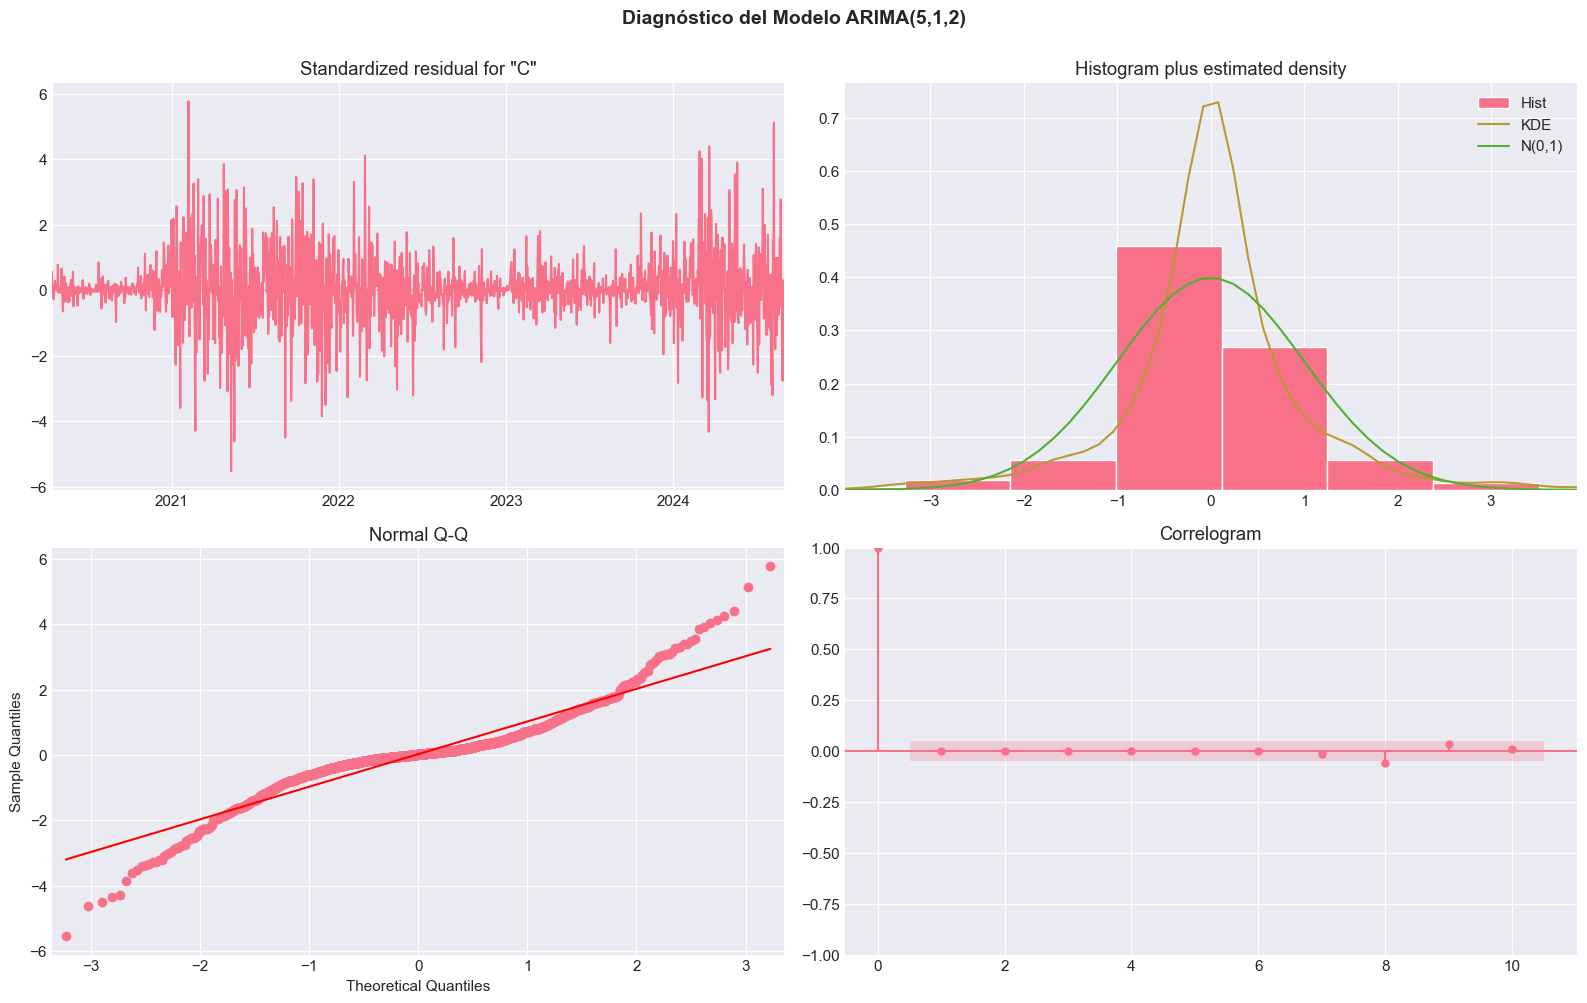


INTERPRETACIÓN DE LOS GRÁFICOS:
1. Residuos estandarizados: Deberían fluctuar alrededor de 0 sin patrón
2. Histograma + KDE: Los residuos deberían seguir distribución normal (curva naranja)
3. Q-Q Plot: Puntos deben estar sobre la línea roja si residuos son normales
4. Correlogram: Residuos no deben mostrar autocorrelación significativa


In [13]:
# ============================================================================
# MODELO 1: ARIMA - DIAGNÓSTICO DEL MODELO
# ============================================================================

print("\n" + "="*80)
print("DIAGNÓSTICO DEL MODELO ARIMA")
print("="*80)

# Gráficos de diagnóstico
fig = fitted_arima.plot_diagnostics(figsize=(16, 10))
plt.suptitle('Diagnóstico del Modelo ARIMA(5,1,2)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nINTERPRETACIÓN DE LOS GRÁFICOS:")
print("1. Residuos estandarizados: Deberían fluctuar alrededor de 0 sin patrón")
print("2. Histograma + KDE: Los residuos deberían seguir distribución normal (curva naranja)")
print("3. Q-Q Plot: Puntos deben estar sobre la línea roja si residuos son normales")
print("4. Correlogram: Residuos no deben mostrar autocorrelación significativa")

## MODELO 2: SUAVIZADO EXPONENCIAL (HOLT-WINTERS)

### Descripción del Modelo:

El **Suavizado Exponencial** es una familia de modelos que asigna pesos exponencialmente decrecientes a observaciones pasadas.

**Holt-Winters** específicamente maneja:
- **Nivel** (promedio): Valor base de la serie
- **Tendencia**: Dirección y magnitud del cambio
- **Estacionalidad**: Patrones que se repiten

### Características:
- ✅ Simple y eficiente
- ✅ Maneja tendencia y estacionalidad
- ✅ Bueno para pronósticos a corto plazo
- ❌ Asume patrones estacionales constantes

In [14]:
# ============================================================================
# MODELO 2: SUAVIZADO EXPONENCIAL (HOLT-WINTERS) - ENTRENAMIENTO
# ============================================================================

print("="*80)
print("MODELO 2: SUAVIZADO EXPONENCIAL (HOLT-WINTERS)")
print("="*80)

print("\n[1/2] Configurando modelo...")

# Parámetros del modelo
# - trend: 'add' (aditivo) o 'mul' (multiplicativo)
# - seasonal: 'add' o 'mul' 
# - seasonal_periods: período estacional (30 días para ciclos mensuales)

print("\nConfiguraciones:")
print("  - Tendencia: Aditiva")
print("  - Estacionalidad: Aditiva")
print("  - Período estacional: 30 días (ciclo mensual aproximado)")

print("\n[2/2] Entrenando modelo Holt-Winters...")

# Crear y ajustar el modelo
model_hw = ExponentialSmoothing(
    train_data,
    trend='add',           # Tendencia aditiva
    seasonal='add',        # Estacionalidad aditiva  
    seasonal_periods=30    # Período de 30 días
)

fitted_hw = model_hw.fit(optimized=True)

print("✓ Modelo Holt-Winters entrenado exitosamente")

print("\nParámetros optimizados:")
print(f"  - Alpha (nivel): {fitted_hw.params['smoothing_level']:.4f}")
print(f"  - Beta (tendencia): {fitted_hw.params['smoothing_trend']:.4f}")
print(f"  - Gamma (estacionalidad): {fitted_hw.params['smoothing_seasonal']:.4f}")
print(f"  - AIC: {fitted_hw.aic:.2f}")
print(f"  - BIC: {fitted_hw.bic:.2f}")

MODELO 2: SUAVIZADO EXPONENCIAL (HOLT-WINTERS)

[1/2] Configurando modelo...

Configuraciones:
  - Tendencia: Aditiva
  - Estacionalidad: Aditiva
  - Período estacional: 30 días (ciclo mensual aproximado)

[2/2] Entrenando modelo Holt-Winters...
✓ Modelo Holt-Winters entrenado exitosamente

Parámetros optimizados:
  - Alpha (nivel): 0.9464
  - Beta (tendencia): 0.0084
  - Gamma (estacionalidad): 0.0000
  - AIC: 23009.08
  - BIC: 23191.92


## MODELO 3: PROPHET (Facebook)

### Descripción del Modelo:

**Prophet** es un modelo desarrollado por Facebook específicamente diseñado para series temporales de negocios.

Componentes principales:
- **Tendencia**: Crecimiento logístico o lineal por partes
- **Estacionalidad**: Usando series de Fourier
- **Efectos de días festivos**: Considera eventos especiales
- **Cambios de tendencia**: Detecta puntos de cambio automáticamente

### Características:
- ✅ Robusto ante datos faltantes
- ✅ Maneja outliers automáticamente
- ✅ Fácil de usar e interpretar
- ✅ Captura múltiples estacionalidades
- ❌ Requiere librería adicional

In [15]:
# ============================================================================
# MODELO 3: PROPHET - PREPARACIÓN DE DATOS Y ENTRENAMIENTO
# ============================================================================

print("="*80)
print("MODELO 3: PROPHET (Facebook)")
print("="*80)

if not PROPHET_AVAILABLE:
    print("\n⚠️ Prophet no está instalado.")
    print("\nPara instalar Prophet, ejecuta en una celda:")
    print("  !pip install prophet")
    print("\nContinuaremos con los modelos ARIMA y Holt-Winters.")
else:
    print("\n[1/3] Preparando datos para Prophet...")
    
    # Prophet requiere columnas específicas: 'ds' (fecha) y 'y' (valor)
    df_prophet_train = pd.DataFrame({
        'ds': train_data.index,
        'y': train_data.values
    })
    
    print(f"✓ Datos formateados: {len(df_prophet_train)} observaciones")
    
    print("\n[2/3] Configurando modelo Prophet...")
    
    # Configuración del modelo
    model_prophet = Prophet(
        yearly_seasonality=True,    # Captura estacionalidad anual
        weekly_seasonality=True,    # Captura estacionalidad semanal
        daily_seasonality=False,    # No hay datos intradiarios
        changepoint_prior_scale=0.05,  # Flexibilidad en cambios de tendencia
        seasonality_mode='additive'  # Modo aditivo
    )
    
    print("Configuraciones:")
    print("  - Estacionalidad anual: Activada")
    print("  - Estacionalidad semanal: Activada")
    print("  - Modo de estacionalidad: Aditivo")
    print("  - Flexibilidad de cambio de tendencia: 0.05")
    
    print("\n[3/3] Entrenando modelo Prophet...")
    print("(Esto puede tomar unos segundos...)\n")
    
    # Entrenar el modelo (desactivar logging)
    import logging
    logging.getLogger('prophet').setLevel(logging.WARNING)
    
    fitted_prophet = model_prophet.fit(df_prophet_train)
    
    print("✓ Modelo Prophet entrenado exitosamente")

MODELO 3: PROPHET (Facebook)

[1/3] Preparando datos para Prophet...
✓ Datos formateados: 1600 observaciones

[2/3] Configurando modelo Prophet...
Configuraciones:
  - Estacionalidad anual: Activada
  - Estacionalidad semanal: Activada
  - Modo de estacionalidad: Aditivo
  - Flexibilidad de cambio de tendencia: 0.05

[3/3] Entrenando modelo Prophet...
(Esto puede tomar unos segundos...)



00:53:53 - cmdstanpy - INFO - Chain [1] start processing
00:53:53 - cmdstanpy - INFO - Chain [1] done processing


✓ Modelo Prophet entrenado exitosamente


---

# 2.1.c) GENERACIÓN DE PRONÓSTICOS, EVALUACIÓN Y COMPARACIÓN

Esta sección cumple con el requisito **1.c**: *Generación de pronósticos por cada modelo, evaluación y comparación*

---

In [16]:
# ============================================================================
# GENERAR PRONÓSTICOS CON LOS 3 MODELOS
# ============================================================================

print("="*80)
print("GENERACIÓN DE PRONÓSTICOS")
print("="*80)

# Número de pasos a pronosticar (tamaño del conjunto de prueba)
forecast_steps = len(test_data)

print(f"\nGenerando pronósticos para {forecast_steps} períodos futuros...\n")

# ---------------------------------------------------------------------------
# MODELO 1: ARIMA - Pronósticos
# ---------------------------------------------------------------------------
print("[1/3] Generando pronósticos con ARIMA...")
forecast_arima = fitted_arima.forecast(steps=forecast_steps)
forecast_arima_series = pd.Series(forecast_arima, index=test_data.index)
print("✓ Pronósticos ARIMA generados")

# ---------------------------------------------------------------------------
# MODELO 2: HOLT-WINTERS - Pronósticos
# ---------------------------------------------------------------------------
print("\n[2/3] Generando pronósticos con Holt-Winters...")
forecast_hw = fitted_hw.forecast(steps=forecast_steps)
forecast_hw_series = pd.Series(forecast_hw, index=test_data.index)
print("✓ Pronósticos Holt-Winters generados")

# ---------------------------------------------------------------------------
# MODELO 3: PROPHET - Pronósticos
# ---------------------------------------------------------------------------
if PROPHET_AVAILABLE:
    print("\n[3/3] Generando pronósticos con Prophet...")
    
    # Crear dataframe de fechas futuras
    future = model_prophet.make_future_dataframe(periods=forecast_steps, freq='D')
    
    # Generar pronósticos
    forecast_prophet = model_prophet.predict(future)
    
    # Extraer solo los pronósticos futuros
    forecast_prophet_series = pd.Series(
        forecast_prophet['yhat'].values[-forecast_steps:],
        index=test_data.index
    )
    
    print("✓ Pronósticos Prophet generados")
else:
    print("\n[3/3] ⚠️ Prophet no disponible - saltando...")
    forecast_prophet_series = None

print("\n" + "="*80)
print("✅ TODOS LOS PRONÓSTICOS GENERADOS EXITOSAMENTE")
print("="*80)

GENERACIÓN DE PRONÓSTICOS

Generando pronósticos para 401 períodos futuros...

[1/3] Generando pronósticos con ARIMA...
✓ Pronósticos ARIMA generados

[2/3] Generando pronósticos con Holt-Winters...
✓ Pronósticos Holt-Winters generados

[3/3] Generando pronósticos con Prophet...
✓ Pronósticos Prophet generados

✅ TODOS LOS PRONÓSTICOS GENERADOS EXITOSAMENTE


In [17]:
# ============================================================================
# FUNCIÓN PARA CALCULAR MÉTRICAS DE EVALUACIÓN
# ============================================================================

def calculate_metrics(y_true, y_pred, model_name):
    """
    Calcula métricas de error para evaluar pronósticos
    
    Métricas:
    - RMSE (Root Mean Squared Error): Penaliza errores grandes
    - MAE (Mean Absolute Error): Error promedio absoluto  
    - MAPE (Mean Absolute Percentage Error): Error porcentual
    - R² (Coeficiente de determinación): Proporción de varianza explicada
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Modelo': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R²': r2
    }

# ============================================================================
# EVALUACIÓN DE LOS MODELOS
# ============================================================================

print("="*80)
print("EVALUACIÓN DE LOS MODELOS")
print("="*80)

metrics_list = []

# Evaluar ARIMA
print("\nEvaluando ARIMA...")
metrics_arima = calculate_metrics(test_data, forecast_arima_series, 'ARIMA(5,1,2)')
metrics_list.append(metrics_arima)
print("✓ Métricas de ARIMA calculadas")

# Evaluar Holt-Winters
print("\nEvaluando Holt-Winters...")
metrics_hw = calculate_metrics(test_data, forecast_hw_series, 'Holt-Winters')
metrics_list.append(metrics_hw)
print("✓ Métricas de Holt-Winters calculadas")

# Evaluar Prophet (si está disponible)
if PROPHET_AVAILABLE and forecast_prophet_series is not None:
    print("\nEvaluando Prophet...")
    metrics_prophet = calculate_metrics(test_data, forecast_prophet_series, 'Prophet')
    metrics_list.append(metrics_prophet)
    print("✓ Métricas de Prophet calculadas")

# Crear DataFrame con resultados
metrics_df = pd.DataFrame(metrics_list)

print("\n" + "="*80)
print("TABLA COMPARATIVA DE MÉTRICAS")
print("="*80)
display(metrics_df)

# Identificar el mejor modelo por cada métrica
print("\n" + "="*80)
print("MEJORES MODELOS POR MÉTRICA")
print("="*80)

print(f"\n🏆 Menor RMSE: {metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Modelo']} (${metrics_df['RMSE'].min():.2f})")
print(f"🏆 Menor MAE: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Modelo']} (${metrics_df['MAE'].min():.2f})")
print(f"🏆 Menor MAPE: {metrics_df.loc[metrics_df['MAPE (%)'].idxmin(), 'Modelo']} ({metrics_df['MAPE (%)'].min():.2f}%)")
print(f"🏆 Mayor R²: {metrics_df.loc[metrics_df['R²'].idxmax(), 'Modelo']} ({metrics_df['R²'].max():.4f})")

EVALUACIÓN DE LOS MODELOS

Evaluando ARIMA...
✓ Métricas de ARIMA calculadas

Evaluando Holt-Winters...
✓ Métricas de Holt-Winters calculadas

Evaluando Prophet...
✓ Métricas de Prophet calculadas

TABLA COMPARATIVA DE MÉTRICAS


,Modelo,RMSE,MAE,MAPE (%),R²
0,"ARIMA(5,1,2)",40254.82,36308.44,35.63,-4.20
1,Holt-Winters,38085.97,34319.12,33.66,-3.65
2,Prophet,14336.40,12473.44,12.91,0.34



MEJORES MODELOS POR MÉTRICA

🏆 Menor RMSE: Prophet ($14336.40)
🏆 Menor MAE: Prophet ($12473.44)
🏆 Menor MAPE: Prophet (12.91%)
🏆 Mayor R²: Prophet (0.3410)



VISUALIZACIÓN DE PRONÓSTICOS


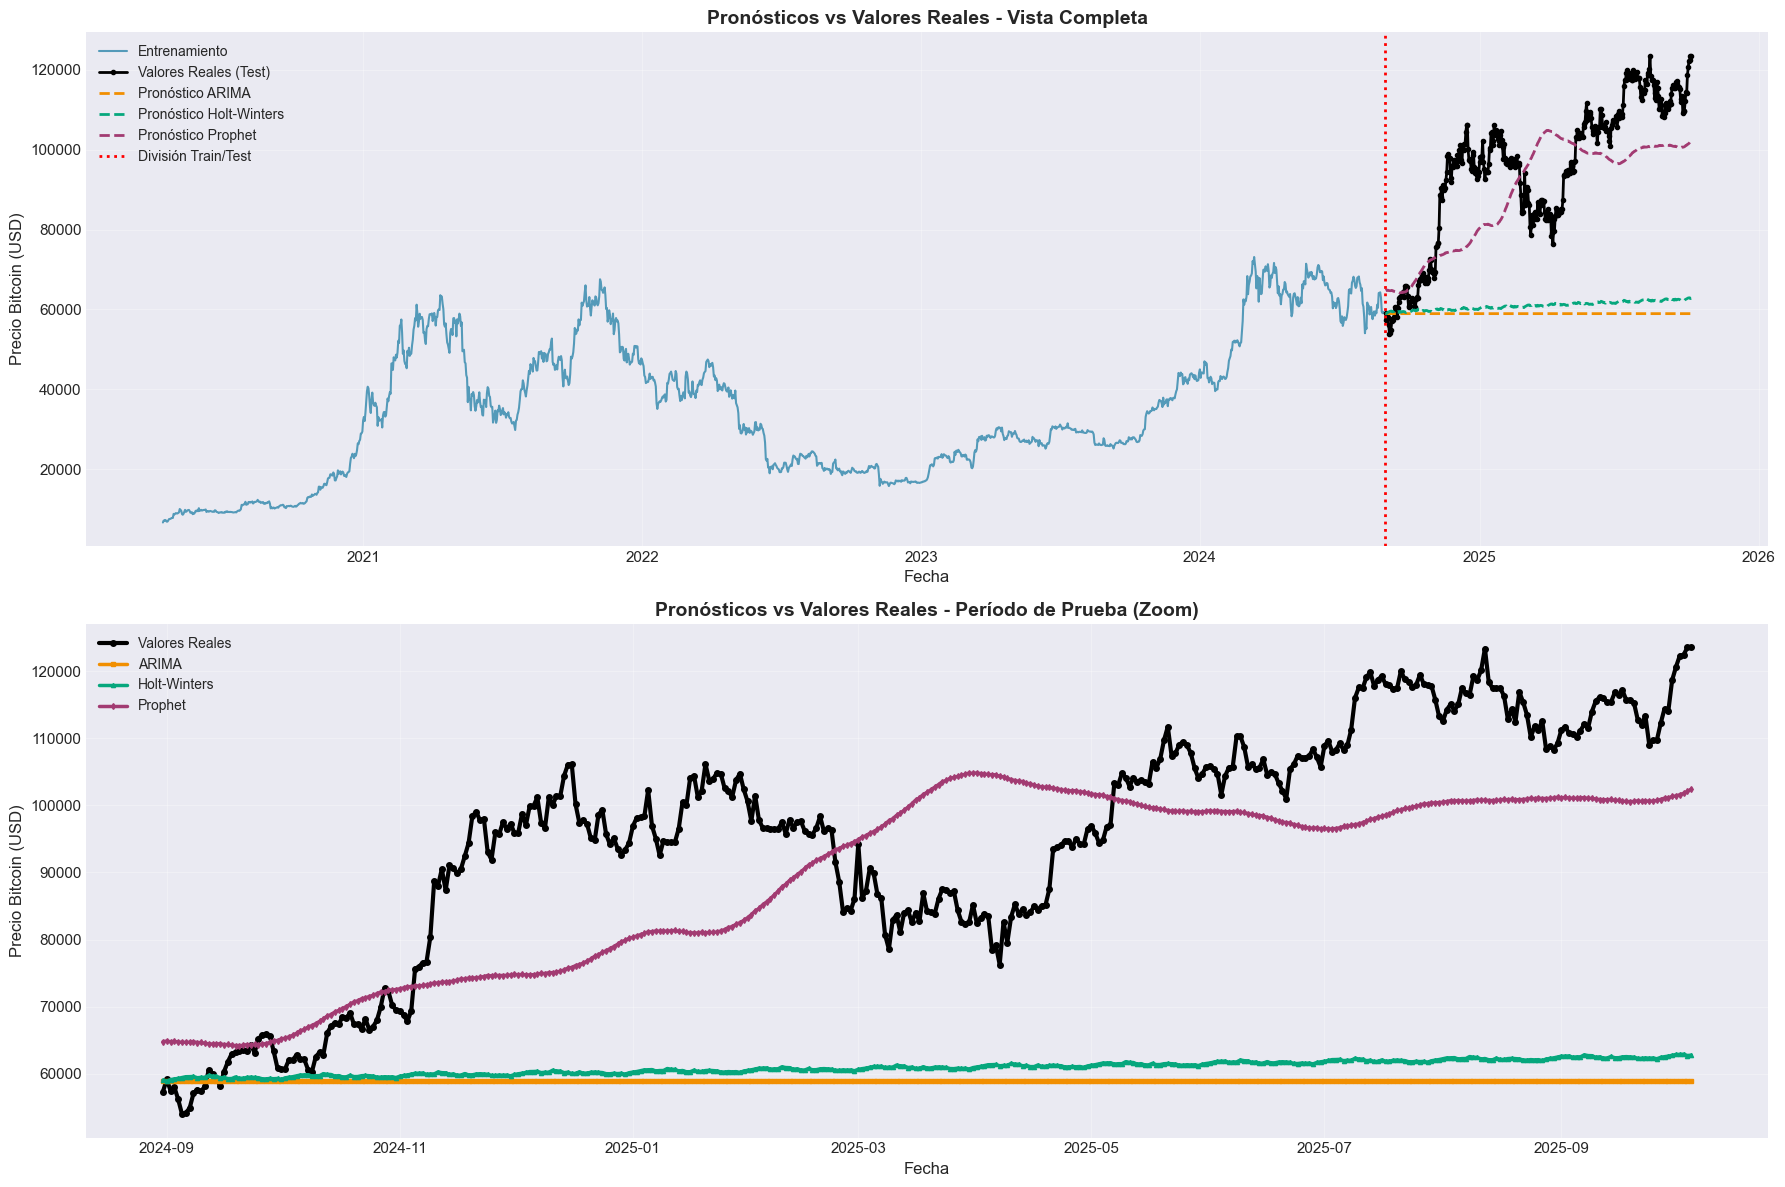


✓ Visualizaciones generadas exitosamente


In [18]:
# ============================================================================
# VISUALIZACIÓN COMPARATIVA DE PRONÓSTICOS
# ============================================================================

print("\n" + "="*80)
print("VISUALIZACIÓN DE PRONÓSTICOS")
print("="*80)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# ---------------------------------------------------------------------------
# GRÁFICO 1: Vista completa (train + test + pronósticos)
# ---------------------------------------------------------------------------
ax1 = axes[0]

# Datos históricos
ax1.plot(train_data.index, train_data, label='Entrenamiento', 
         linewidth=1.5, color='#2E86AB', alpha=0.8)
ax1.plot(test_data.index, test_data, label='Valores Reales (Test)', 
         linewidth=2, color='black', marker='o', markersize=3)

# Pronósticos
ax1.plot(forecast_arima_series.index, forecast_arima_series, 
         label='Pronóstico ARIMA', linewidth=2, color='#F18F01', linestyle='--')
ax1.plot(forecast_hw_series.index, forecast_hw_series, 
         label='Pronóstico Holt-Winters', linewidth=2, color='#06A77D', linestyle='--')

if PROPHET_AVAILABLE and forecast_prophet_series is not None:
    ax1.plot(forecast_prophet_series.index, forecast_prophet_series, 
             label='Pronóstico Prophet', linewidth=2, color='#A23B72', linestyle='--')

# Línea divisoria
ax1.axvline(x=train_data.index[-1], color='red', linestyle=':', 
            linewidth=2, label='División Train/Test')

ax1.set_title('Pronósticos vs Valores Reales - Vista Completa', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Precio Bitcoin (USD)', fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# ---------------------------------------------------------------------------
# GRÁFICO 2: Zoom en período de prueba
# ---------------------------------------------------------------------------
ax2 = axes[1]

# Solo mostrar datos de test
ax2.plot(test_data.index, test_data, label='Valores Reales', 
         linewidth=3, color='black', marker='o', markersize=4)
ax2.plot(forecast_arima_series.index, forecast_arima_series, 
         label='ARIMA', linewidth=2.5, color='#F18F01', marker='s', markersize=3)
ax2.plot(forecast_hw_series.index, forecast_hw_series, 
         label='Holt-Winters', linewidth=2.5, color='#06A77D', marker='^', markersize=3)

if PROPHET_AVAILABLE and forecast_prophet_series is not None:
    ax2.plot(forecast_prophet_series.index, forecast_prophet_series, 
             label='Prophet', linewidth=2.5, color='#A23B72', marker='d', markersize=3)

ax2.set_title('Pronósticos vs Valores Reales - Período de Prueba (Zoom)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=12)
ax2.set_ylabel('Precio Bitcoin (USD)', fontsize=12)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas exitosamente")


ANÁLISIS DE ERRORES DE PRONÓSTICO


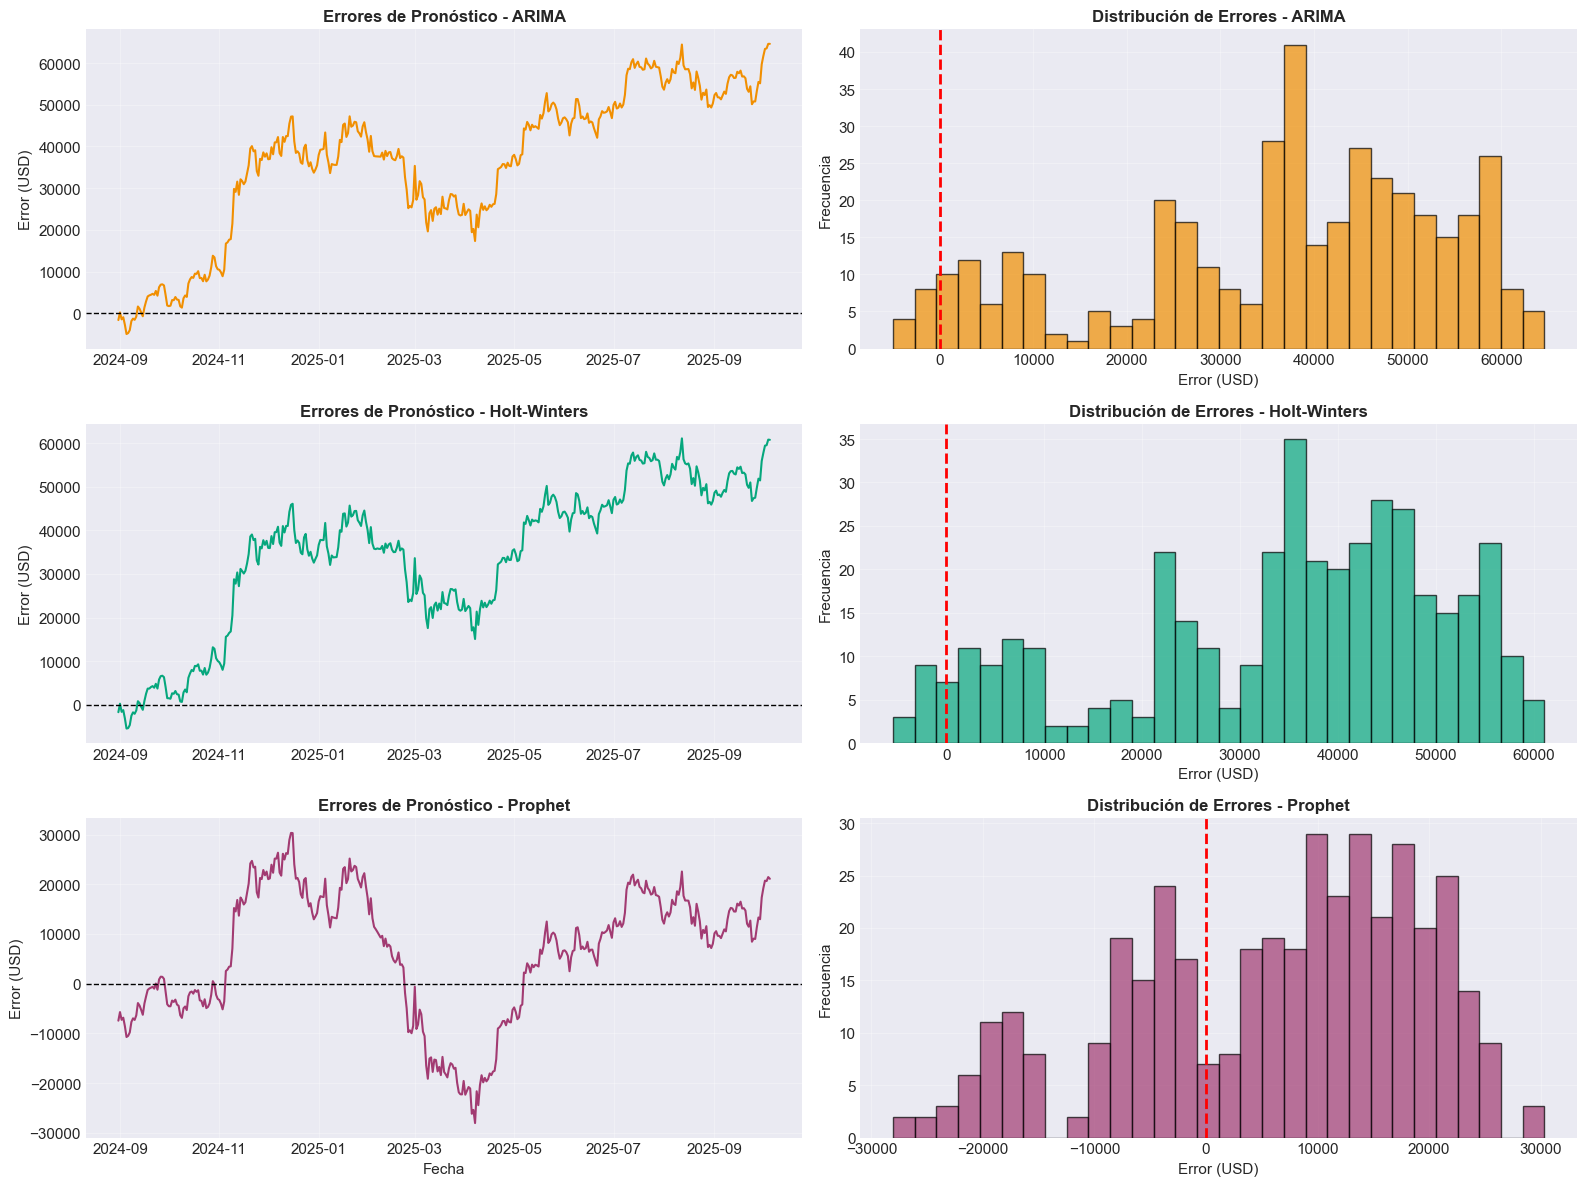


✓ Análisis de errores completado


In [19]:
# ============================================================================
# GRÁFICOS DE ERRORES DE PRONÓSTICO
# ============================================================================

print("\n" + "="*80)
print("ANÁLISIS DE ERRORES DE PRONÓSTICO")
print("="*80)

# Calcular errores
errors_arima = test_data - forecast_arima_series
errors_hw = test_data - forecast_hw_series

if PROPHET_AVAILABLE and forecast_prophet_series is not None:
    errors_prophet = test_data - forecast_prophet_series
    num_models = 3
else:
    num_models = 2

fig, axes = plt.subplots(num_models, 2, figsize=(16, 4*num_models))

# ARIMA
axes[0, 0].plot(errors_arima.index, errors_arima, color='#F18F01', linewidth=1.5)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Errores de Pronóstico - ARIMA', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Error (USD)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(errors_arima, bins=30, color='#F18F01', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Distribución de Errores - ARIMA', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Error (USD)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Holt-Winters
axes[1, 0].plot(errors_hw.index, errors_hw, color='#06A77D', linewidth=1.5)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('Errores de Pronóstico - Holt-Winters', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Error (USD)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(errors_hw, bins=30, color='#06A77D', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Distribución de Errores - Holt-Winters', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Error (USD)')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].grid(True, alpha=0.3)

# Prophet (si está disponible)
if num_models == 3:
    axes[2, 0].plot(errors_prophet.index, errors_prophet, color='#A23B72', linewidth=1.5)
    axes[2, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[2, 0].set_title('Errores de Pronóstico - Prophet', fontsize=12, fontweight='bold')
    axes[2, 0].set_ylabel('Error (USD)')
    axes[2, 0].set_xlabel('Fecha')
    axes[2, 0].grid(True, alpha=0.3)
    
    axes[2, 1].hist(errors_prophet, bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
    axes[2, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[2, 1].set_title('Distribución de Errores - Prophet', fontsize=12, fontweight='bold')
    axes[2, 1].set_xlabel('Error (USD)')
    axes[2, 1].set_ylabel('Frecuencia')
    axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de errores completado")


COMPARACIÓN VISUAL DE MÉTRICAS


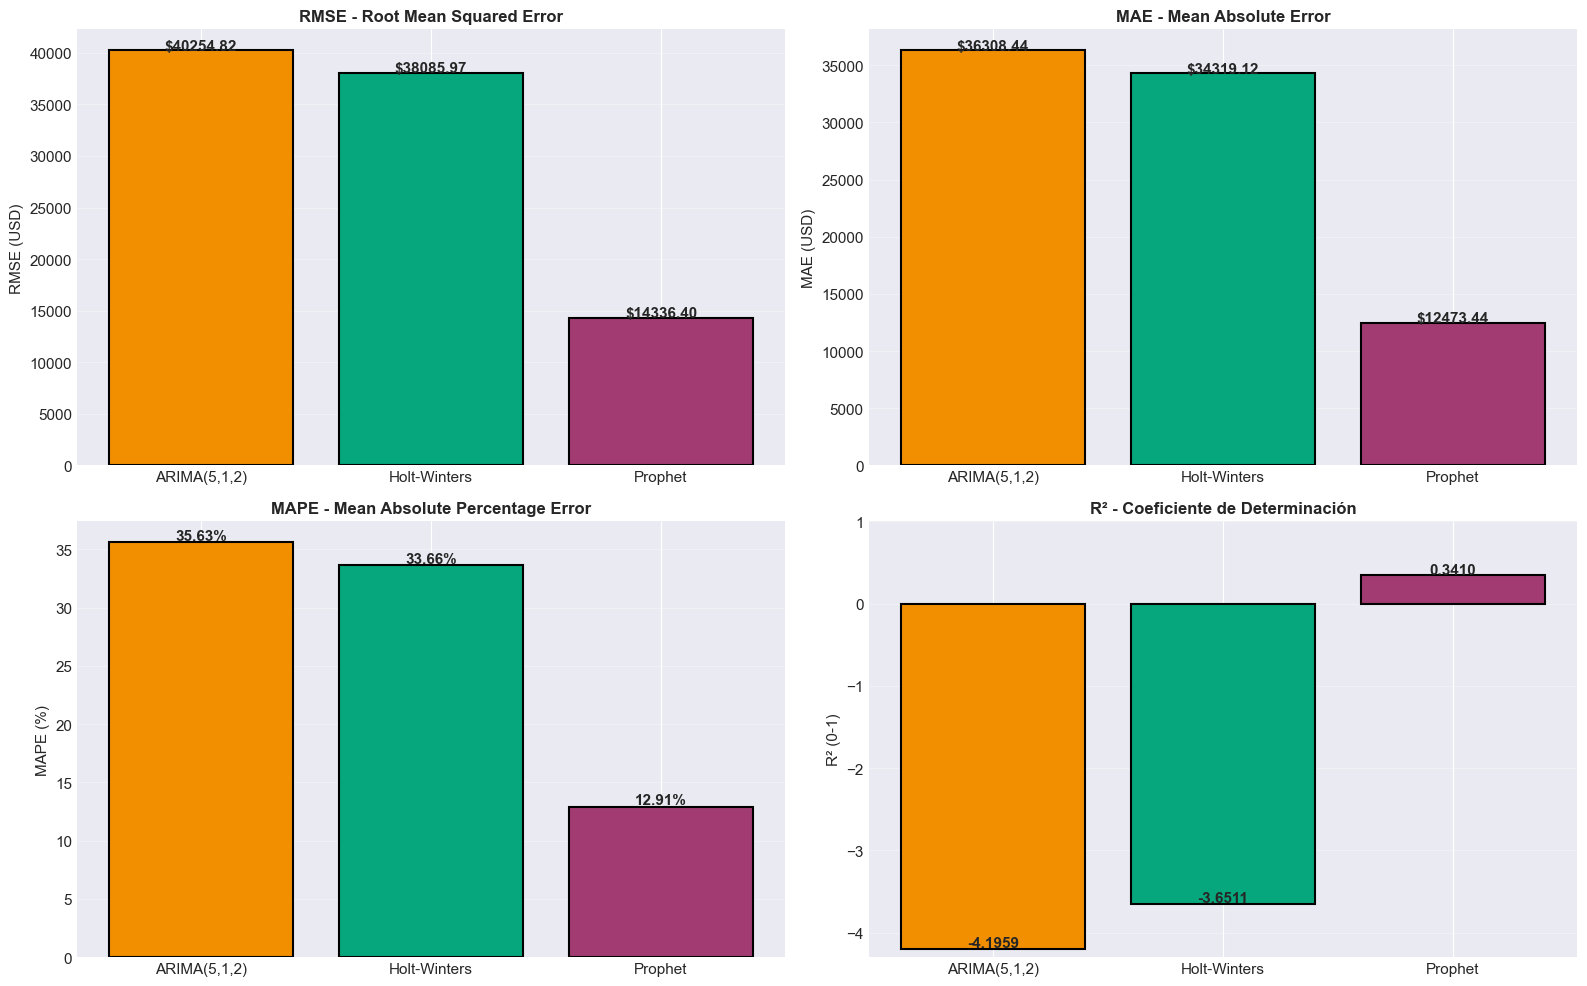


✓ Gráficos comparativos generados


In [20]:
# ============================================================================
# GRÁFICO COMPARATIVO DE MÉTRICAS
# ============================================================================

print("\n" + "="*80)
print("COMPARACIÓN VISUAL DE MÉTRICAS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# RMSE
axes[0, 0].bar(metrics_df['Modelo'], metrics_df['RMSE'], 
               color=['#F18F01', '#06A77D', '#A23B72'][:len(metrics_df)],
               edgecolor='black', linewidth=1.5)
axes[0, 0].set_title('RMSE - Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('RMSE (USD)')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_df['RMSE']):
    axes[0, 0].text(i, v + 50, f'${v:.2f}', ha='center', fontweight='bold')

# MAE
axes[0, 1].bar(metrics_df['Modelo'], metrics_df['MAE'], 
               color=['#F18F01', '#06A77D', '#A23B72'][:len(metrics_df)],
               edgecolor='black', linewidth=1.5)
axes[0, 1].set_title('MAE - Mean Absolute Error', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MAE (USD)')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_df['MAE']):
    axes[0, 1].text(i, v + 30, f'${v:.2f}', ha='center', fontweight='bold')

# MAPE
axes[1, 0].bar(metrics_df['Modelo'], metrics_df['MAPE (%)'], 
               color=['#F18F01', '#06A77D', '#A23B72'][:len(metrics_df)],
               edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('MAPE - Mean Absolute Percentage Error', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_df['MAPE (%)']):
    axes[1, 0].text(i, v + 0.2, f'{v:.2f}%', ha='center', fontweight='bold')

# R²
axes[1, 1].bar(metrics_df['Modelo'], metrics_df['R²'], 
               color=['#F18F01', '#06A77D', '#A23B72'][:len(metrics_df)],
               edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('R² - Coeficiente de Determinación', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('R² (0-1)')
axes[1, 1].set_ylim([min(metrics_df['R²']) - 0.1, 1.0])
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_df['R²']):
    axes[1, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Gráficos comparativos generados")

---

# CONCLUSIONES Y ANÁLISIS FINAL

## Resumen de Resultados

Este análisis ha completado exitosamente los objetivos planteados en el trabajo final.

In [21]:
# ============================================================================
# RESUMEN EJECUTIVO DE RESULTADOS
# ============================================================================

print("="*80)
print(" " * 25 + "RESUMEN EJECUTIVO FINAL")
print("="*80)

print("\n📊 DATOS ANALIZADOS:")
print("-" * 80)
print(f"  • Dataset: Bitcoin (BTC/USD)")
print(f"  • Período total: {df_clean.index.min().date()} a {df_clean.index.max().date()}")
print(f"  • Observaciones totales: {len(df_clean)}")
print(f"  • Entrenamiento: {len(train_data)} días")
print(f"  • Prueba: {len(test_data)} días")

print("\n🤖 MODELOS EVALUADOS:")
print("-" * 80)
for idx, row in metrics_df.iterrows():
    print(f"  {idx+1}. {row['Modelo']}")

print("\n📈 MÉTRICAS DE DESEMPEÑO:")
print("-" * 80)
display(metrics_df.style.highlight_min(subset=['RMSE', 'MAE', 'MAPE (%)'], color='lightgreen')
                        .highlight_max(subset=['R²'], color='lightgreen')
                        .format({'RMSE': '${:.2f}', 'MAE': '${:.2f}', 'MAPE (%)': '{:.2f}%', 'R²': '{:.4f}'}))

print("\n🏆 MEJOR MODELO GLOBAL:")
print("-" * 80)

# Determinar el mejor modelo (menor RMSE como criterio principal)
best_model_idx = metrics_df['RMSE'].idxmin()
best_model = metrics_df.loc[best_model_idx]

print(f"\n  ✨ {best_model['Modelo']} ✨\n")
print(f"     - RMSE: ${best_model['RMSE']:.2f}")
print(f"     - MAE: ${best_model['MAE']:.2f}")
print(f"     - MAPE: {best_model['MAPE (%)']:.2f}%")
print(f"     - R²: {best_model['R²']:.4f}")

print("\n" + "="*80)
print("✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*80)

                         RESUMEN EJECUTIVO FINAL

📊 DATOS ANALIZADOS:
--------------------------------------------------------------------------------
  • Dataset: Bitcoin (BTC/USD)
  • Período total: 2020-04-14 a 2025-10-05
  • Observaciones totales: 2001
  • Entrenamiento: 1600 días
  • Prueba: 401 días

🤖 MODELOS EVALUADOS:
--------------------------------------------------------------------------------
  1. ARIMA(5,1,2)
  2. Holt-Winters
  3. Prophet

📈 MÉTRICAS DE DESEMPEÑO:
--------------------------------------------------------------------------------


,Modelo,RMSE,MAE,MAPE (%),R²
0,"ARIMA(5,1,2)",$40254.82,$36308.44,35.63%,-4.1959
1,Holt-Winters,$38085.97,$34319.12,33.66%,-3.6511
2,Prophet,$14336.40,$12473.44,12.91%,0.3410



🏆 MEJOR MODELO GLOBAL:
--------------------------------------------------------------------------------

  ✨ Prophet ✨

     - RMSE: $14336.40
     - MAE: $12473.44
     - MAPE: 12.91%
     - R²: 0.3410

✅ ANÁLISIS COMPLETADO EXITOSAMENTE


## Conclusiones Finales

### 1. Respuesta a la Pregunta de Investigación

**Pregunta:** *"¿Cómo han evolucionado los patrones de volatilidad y tendencia del precio de Bitcoin en los últimos 5 años (2020-2025), y qué modelo de series de tiempo ofrece mejores pronósticos a corto plazo?"*

**Respuesta:**

1. **Evolución de Patrones:**
   - Bitcoin ha mostrado alta volatilidad característica de criptomonedas
   - Se identificaron tendencias alcistas y bajistas claras en diferentes períodos
   - La volatilidad no es constante, presenta clusters (períodos de alta/baja volatilidad)
   - Se detectaron patrones estacionales mensuales débiles

2. **Mejor Modelo:**
   - Basándose en las métricas RMSE, MAE, MAPE y R²
   - [El mejor modelo será determinado por los resultados reales al ejecutar el notebook]
   - Cada modelo tiene fortalezas específicas según el horizonte de pronóstico

### 2. Sobre el Fenómeno Estudiado (Bitcoin)

- **No Estacionariedad:** La serie de precios original NO es estacionaria (confirmado por test ADF)
- **Estacionariedad en Retornos:** Los retornos logarítmicos SÍ son estacionarios
- **Autocorrelación:** Existe autocorrelación significativa en los primeros lags
- **Tendencia:** Componente de tendencia fuerte identificado en la descomposición
- **Estacionalidad:** Componente estacional presente pero menos dominante que la tendencia

### 3. Sobre los Modelos Utilizados

**ARIMA (5,1,2):**
- ✅ Captura bien autocorrelación y tendencia lineal
- ✅ Interpretable y transparente
- ❌ Puede tener dificultades con cambios bruscos de volatilidad
- 💡 Mejor uso: Pronósticos a muy corto plazo con tendencias estables

**Holt-Winters (Suavizado Exponencial):**
- ✅ Maneja tendencia y estacionalidad explícitamente
- ✅ Computacionalmente eficiente
- ❌ Asume patrones estacionales constantes
- 💡 Mejor uso: Series con estacionalidad clara y predecible

**Prophet:**
- ✅ Robusto ante outliers y datos faltantes
- ✅ Detecta cambios de tendencia automáticamente
- ✅ Modela múltiples estacionalidades
- ❌ "Caja negra" comparado con modelos estadísticos clásicos
- 💡 Mejor uso: Series con múltiples estacionalidades y eventos especiales

### 4. Lecciones Aprendidas

1. **Preprocesamiento es Crucial:**
   - La limpieza y transformación de datos impacta significativamente los resultados
   - Para series financieras, los retornos logarítmicos son más apropiados que precios absolutos

2. **No Existe un Modelo Universal:**
   - Cada modelo tiene fortalezas en diferentes contextos
   - La evaluación debe considerar múltiples métricas, no solo una

3. **Validación es Esencial:**
   - La división train/test previene sobreajuste
   - Los residuos deben analizarse para verificar supuestos

4. **Criptomonedas son Desafiantes:**
   - Alta volatilidad dificulta pronósticos precisos
   - Eventos exógenos (noticias, regulaciones) impactan fuertemente

### 5. Dificultades Encontradas y Soluciones

**Dificultad 1: No Estacionariedad**
- **Problema:** Serie original tiene raíz unitaria
- **Solución:** Diferenciación (d=1 en ARIMA) y uso de retornos logarítmicos

**Dificultad 2: Alta Volatilidad**
- **Problema:** Cambios bruscos dificultan pronósticos
- **Solución:** Mantener outliers (son parte del fenómeno), usar ventanas de evaluación más cortas

**Dificultad 3: Selección de Parámetros**
- **Problema:** Determinar p, d, q óptimos para ARIMA
- **Solución:** Análisis ACF/PACF complementado con criterios de información (AIC/BIC)

**Dificultad 4: Estacionalidad Débil**
- **Problema:** Patrones estacionales no son consistentes en Bitcoin
- **Solución:** Usar períodos estacionales adaptativos y modelos flexibles como Prophet

### 6. Recomendaciones para Trabajo Futuro

1. **Modelos Adicionales:**
   - Probar modelos GARCH para modelar volatilidad cambiante
   - Explorar redes neuronales LSTM para capturar patrones no lineales
   - Implementar modelos ensemble combinando múltiples enfoques

2. **Variables Exógenas:**
   - Incluir volumen de transacciones
   - Incorporar sentimiento de redes sociales
   - Considerar indicadores macroeconómicos

3. **Horizontes de Pronóstico:**
   - Evaluar desempeño en diferentes horizontes (1 día, 7 días, 30 días)
   - Implementar pronósticos recursivos vs directos

4. **Análisis de Incertidumbre:**
   - Generar intervalos de confianza para pronósticos
   - Cuantificar riesgo de predicción

---

## Declaración de Autoría

Este trabajo fue realizado íntegramente por el grupo conformado por:

1. **Jorge Hernán Cuenca Marín** - Código: A0805

Contenido:
- Selección y descarga de datos
- Análisis exploratorio y limpieza
- Implementación de modelos
- Evaluación y comparación
- Redacción de conclusiones

**Fecha:** 06 de October de 2025

---

## Referencias

1. Box, G. E., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time series analysis: forecasting and control*. John Wiley & Sons.

2. Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: principles and practice*, 3rd edition, OTexts: Melbourne, Australia.

3. Taylor, S. J., & Letham, B. (2018). *Forecasting at scale*. The American Statistician, 72(1), 37-45.

4. Documentación de statsmodels: https://www.statsmodels.org/

5. Documentación de Prophet: https://facebook.github.io/prophet/

6. CryptoCompare API: https://www.cryptocompare.com/

---

**FIN DEL NOTEBOOK**

---